In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb


In [3]:
def fill_synthesis(x, method="mean"):
    for col in x.columns:
        if 'temperature' in col or 'time' in col:
            if method == "mean":
                col_fill = x[col][x[col] != 0].mean()  
            elif method == "median":
                col_fill = x[col][x[col] != 0].median() 
            else:
                raise ValueError("Invalid method. Please choose 'mean' or 'median'.")
            x[col].replace(0, col_fill, inplace=True)
    return x

def fill_nan(x,method="mean"):
    for col in x.columns:
        if method == "mean":
            col_fill = x[col][x[col] != 0].mean() 
        elif method == "median":
            col_fill = x[col][x[col] != 0].median()  
        elif method == "mode":
            col_fill = x[col][x[col] != 0].mode()  
        else:
            raise ValueError("Invalid method. Please choose 'mean' ,'mode',or 'median'.")
        x[col].replace(0, col_fill, inplace=True)
    return x

def filter_features(x_catalyst):
    print('origin:',x_catalyst.shape)
    column_sums = x_catalyst.sum()
    columns_less_than_0 = column_sums[column_sums < 1].index.tolist()
    x_catalyst = x_catalyst.drop(columns=columns_less_than_0)
    print('filter:',x_catalyst.shape)
    return x_catalyst
    
    

In [4]:
def model_tuning(x, y,model,param,random_state=75):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)
    results_test = {}
    result_train = {}
    grid_model = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-1,verbose=1)
    grid_model.fit(x_train,y_train)  
    y_pred = grid_model.predict(x_test)
    y_pred_train = grid_model.predict(x_train)
    mse = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2 = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    results_test[model] = {'MSE': mse, 'R2': r2}
    result_train[model] = {'MSE': mse_train, 'R2': r2_train}
    print(f' MSE_train: {mse_train:.4f}, R2: {r2_train:.4f}')
    print(f' MSE_test: {mse:.4f}, R2: {r2:.4f}')
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.weight'] = 'bold' 
    fig, axs = plt.subplots(1, 1, figsize=(6, 4),dpi=600)  
    plt.rcParams['font.family'] = 'Arial'
    axs.scatter(y_train, y_pred_train, color='c', alpha=0.75,label='Train set (Conversion)')
    axs.scatter(y_test, y_pred, color='Magenta', marker='p', alpha=0.75,label='Test set (Conversion)')
    axs.plot([0, 1.1], [0, 1.1], color='SlateGray', linestyle='--',label = 'Actual = Predicted') 
    #axs.set_title('XGBR model',fontsize=10,fontweight='bold')
    axs.set_xlabel('Actual Values',fontsize=12,fontweight='bold')
    axs.set_ylabel('Predicted Values',fontsize=12,fontweight='bold')

    axs.text(0.65, 0.2, 'R²_train = {:.3f}'.format(r2_train), fontsize=10, color='black')
    axs.text(0.65, 0.1, 'R²_test = {:.3f}'.format(r2), fontsize=10, color='black')#MediumBlue
    axs.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    axs.legend(loc='upper left') 
    axs.legend()
    #plt.show()
    #plt.savefig('conversion_ML.svg') 
    return x_train,x_test, y_train,y_test,y_pred,y_pred_train,grid_model

def model_train(x, y,model,random_state=75):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)
    
    results_test = {}
    result_train = {}
    model_xgb = model
    model_xgb.fit(x_train, y_train)
    y_pred = model_xgb.predict(x_test)
    y_pred_train = model_xgb.predict(x_train)
    mse = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2 = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    
    results_test[model_xgb] = {'MSE': mse, 'R2': r2}
    result_train[model_xgb] = {'MSE': mse_train, 'R2': r2_train}
    
    print(f' MSE_train: {mse_train:.4f}, R2: {r2_train:.4f}')
    print(f'- MSE_test: {mse:.4f}, R2: {r2:.4f}')
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.weight'] = 'bold' 
    fig, axs = plt.subplots(1, 1, figsize=(6, 4),dpi=600)  
    plt.rcParams['font.family'] = 'Arial'
    axs.scatter(y_train, y_pred_train, color='c', alpha=0.75,label='Train set (Conversion)')
    axs.scatter(y_test, y_pred, color='Magenta', marker='p', alpha=0.75,label='Test set (Conversion)')
    axs.plot([0, 1.1], [0, 1.1], color='SlateGray', linestyle='--',label = 'Actual = Predicted') 
    #axs.set_title('XGBR model',fontsize=10,fontweight='bold')
    axs.set_xlabel('Actual Values',fontsize=12,fontweight='bold')
    axs.set_ylabel('Predicted Values',fontsize=12,fontweight='bold')

    axs.text(0.65, 0.2, 'R²_train = {:.3f}'.format(r2_train), fontsize=10, color='black')
    axs.text(0.65, 0.1, 'R²_test = {:.3f}'.format(r2), fontsize=10, color='black')#MediumBlue
    axs.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    axs.legend(loc='upper left') 
    axs.legend()
    #plt.show()
    #plt.savefig('conversion_ML.svg') 
    return x_train,x_test, y_train,y_test,y_pred,y_pred_train,model_xgb


# data

In [5]:
method = pd.read_excel('../data/method.xlsx')
materials = pd.read_excel('../data/onehot_materials.xlsx')
synthesis = pd.read_excel('../data/synthesis.xlsx')
temperature = pd.read_excel('../data/temperature.xlsx')
GHSV = pd.read_excel('../data/GHSV.xlsx')
materials_ascii = pd.read_excel('../data/ascii_materials.xlsx')
Conversion = pd.read_excel('../data/Conversion.xlsx')

In [6]:
x_method = method
x_materials = materials
x_materials_ascii = materials_ascii
x_synthesis = synthesis
x_temperature = pd.DataFrame(temperature['temperature_K_average'])
x_GHSV = pd.DataFrame(GHSV['GHSV_average(h-1)'])
x_GHSV = x_GHSV.astype(int)
y_Conversion = pd.DataFrame(Conversion['Conversion_average'])

In [7]:

#df_filtered = data[data['Selectivity'] != 0]

## missing values

In [8]:
x_materials = filter_features(x_materials)
x_synthesis = fill_synthesis(x_synthesis)
x_temperature = fill_nan(x_temperature)
x_GHSV = fill_nan(x_GHSV)
y_Conversion = fill_nan(y_Conversion)

origin: (446, 362)
filter: (446, 362)


In [9]:
x_element = filter_features(x_element)

origin: (446, 86)
filter: (446, 53)


## outlier

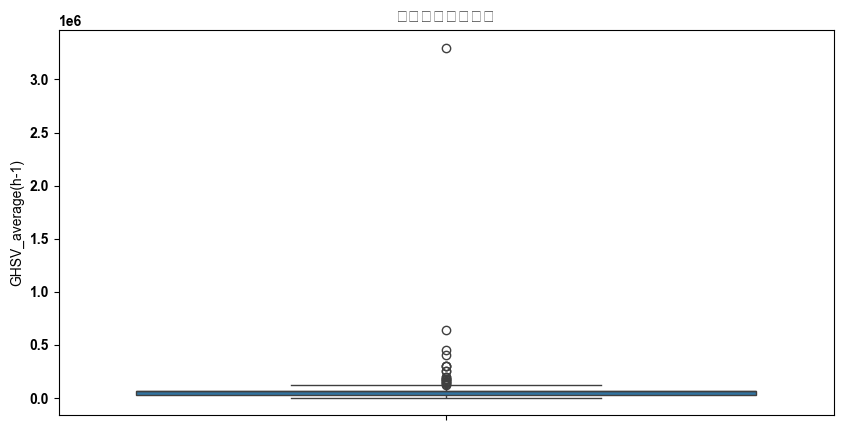

Q1: 30000.0
Q3: 66845.0
IQR: 36845.0
下界: -25267.5
上界: 122112.5
检测到的异常值数量：21
     GHSV_average(h-1)
1               450000
11              400000
28              200000
83              300000
141             130000
149             300000
180             150000
188             640000
199             177000
204             170000
212            3300000
229             180000
270             300000
272             124000
289             140000
315             200000
341             250000
408             177000
435             150000
443             160000
445             250000
替换异常值的均值：50976.16470588235


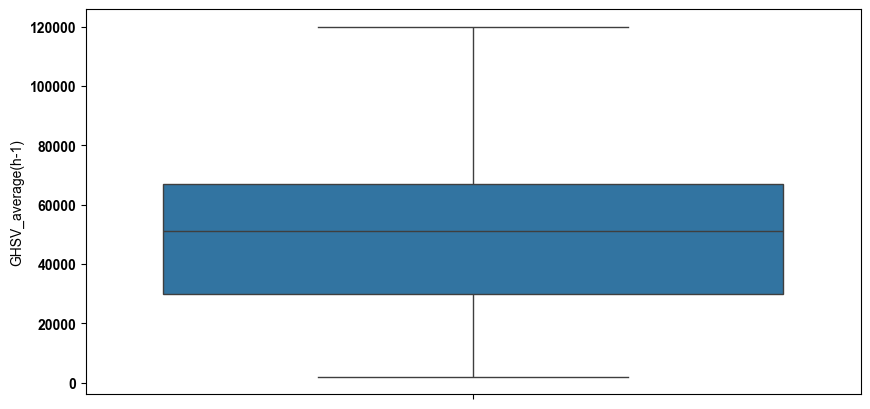

In [10]:
data = x_GHSV
plt.figure(figsize=(10, 5))
sns.boxplot(y='GHSV_average(h-1)', data=x_GHSV)
plt.title('原始数据的箱线图')
plt.show()


Q1 = x_GHSV['GHSV_average(h-1)'].quantile(0.25)
Q3 = x_GHSV['GHSV_average(h-1)'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"下界: {lower_bound}")
print(f"上界: {upper_bound}")


outliers = x_GHSV[(x_GHSV['GHSV_average(h-1)'] < lower_bound) | (x_GHSV['GHSV_average(h-1)'] > upper_bound)]
print(f"检测到的异常值数量：{outliers.shape[0]}")
print(outliers)


mean_value = x_GHSV[(x_GHSV['GHSV_average(h-1)'] >= lower_bound) & (x_GHSV['GHSV_average(h-1)'] <= upper_bound)]['GHSV_average(h-1)'].mean()
print(f"替换异常值的均值：{mean_value}")


x_GHSV_clean = x_GHSV.copy()
x_GHSV_clean.loc[x_GHSV_clean['GHSV_average(h-1)'] < lower_bound, 'GHSV_average(h-1)'] = mean_value
x_GHSV_clean.loc[x_GHSV_clean['GHSV_average(h-1)'] > upper_bound, 'GHSV_average(h-1)'] = mean_value


plt.figure(figsize=(10, 5))
sns.boxplot(y='GHSV_average(h-1)', data=x_GHSV_clean)
plt.show()



# x_GHSV_clean.to_csv('x_GHSV_clean.csv', index=False)


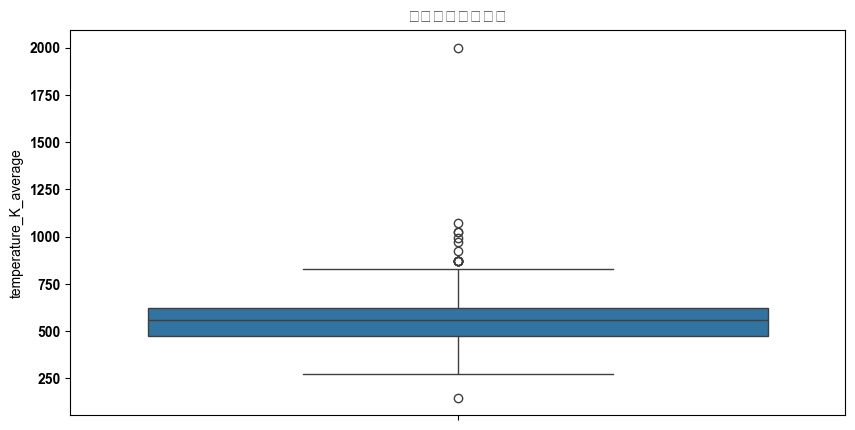

Q1: 473.15
Q3: 623.15
IQR: 150.0
下界: 248.14999999999998
上界: 848.15
检测到的异常值数量：15
     temperature_K_average
29                  873.15
31                  993.15
34                 1023.15
131                 873.15
193                1023.15
206                1073.15
235                 873.15
256                 147.50
293                 973.15
308                 873.15
352                 873.15
364                 923.15
365                 873.00
368                2000.00
391                 873.15
替换异常值的均值：547.2771979563851


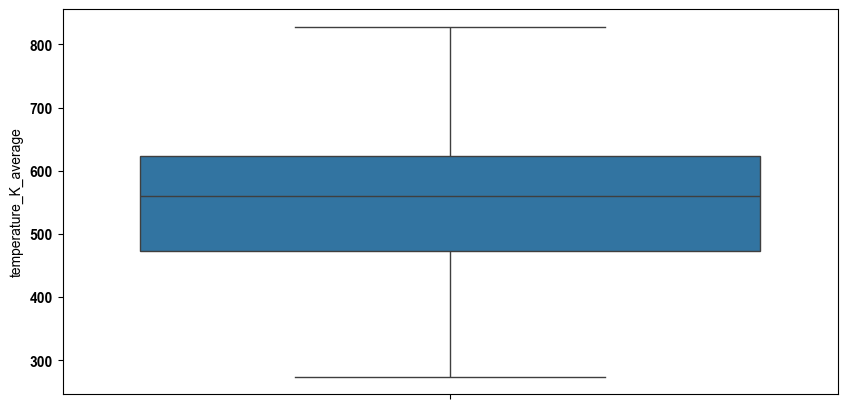

In [11]:
data = x_temperature

plt.figure(figsize=(10, 5))
sns.boxplot(y='temperature_K_average', data=x_temperature)
plt.title('原始数据的箱线图')
plt.show()


Q1 = x_temperature['temperature_K_average'].quantile(0.25)
Q3 = x_temperature['temperature_K_average'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"下界: {lower_bound}")
print(f"上界: {upper_bound}")


outliers = x_temperature[(x_temperature['temperature_K_average'] < lower_bound) | (x_temperature['temperature_K_average'] > upper_bound)]
print(f"检测到的异常值数量：{outliers.shape[0]}")
print(outliers)

mean_value = x_temperature[(x_temperature['temperature_K_average'] >= lower_bound) & (x_temperature['temperature_K_average'] <= upper_bound)]['temperature_K_average'].mean()
print(f"替换异常值的均值：{mean_value}")

x_temperature_clean = x_temperature.copy()
x_temperature_clean.loc[x_temperature_clean['temperature_K_average'] < lower_bound, 'temperature_K_average'] = mean_value
x_temperature_clean.loc[x_temperature_clean['temperature_K_average'] > upper_bound, 'temperature_K_average'] = mean_value


plt.figure(figsize=(10, 5))
sns.boxplot(y='temperature_K_average', data=x_temperature_clean)

plt.show()


# 9. （可选）保存处理后的数据
# x_temperature_clean.to_csv('x_temperature_clean.csv', index=False)


## 特征分布

In [12]:
#Conversion

<Axes: ylabel='Density'>

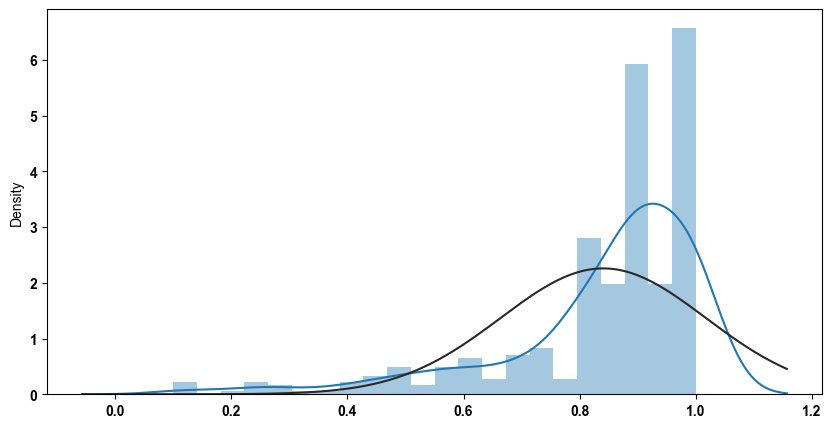

In [13]:
plt.figure(figsize=(10,5))
sns.distplot(y_Conversion,fit=stats.norm)

<Axes: ylabel='Density'>

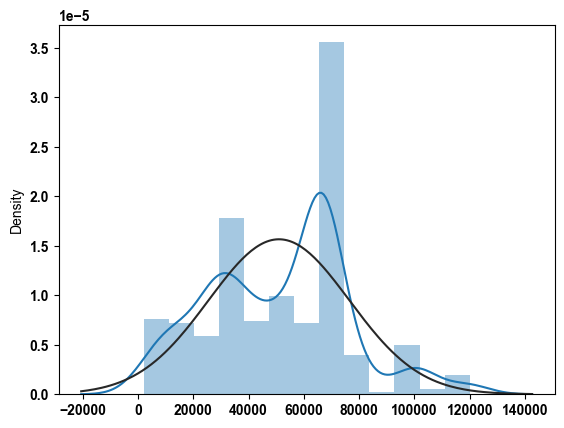

In [14]:
sns.distplot(x_GHSV_clean,fit=stats.norm)

In [15]:
#x_temperature

<Axes: ylabel='Density'>

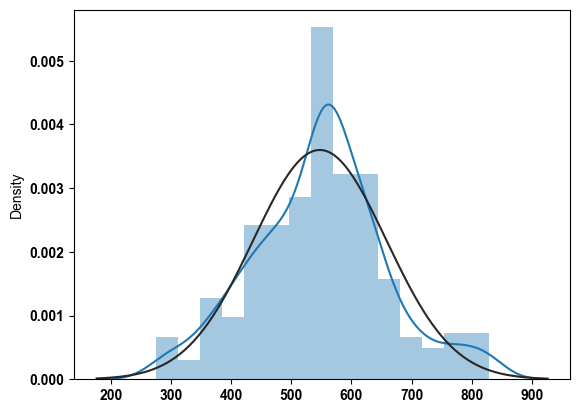

In [16]:
sns.distplot(x_temperature_clean,fit=stats.norm)

## 特征工程

## one_hot_materials

### method_material_systhesis_condition

In [17]:
x_method_material_systhesis_condition = pd.concat([x_method,x_materials,x_synthesis,x_temperature_clean,x_GHSV_clean],axis=1)

In [18]:
x_method_material_systhesis_condition_nor = Normalizer().fit_transform(x_method_material_systhesis_condition)

#### rf

Fitting 5 folds for each of 90 candidates, totalling 450 fits
 MSE_train: 0.0072, R2: 0.7801
 MSE_test: 0.0060, R2: 0.7570
CPU times: user 1.13 s, sys: 350 ms, total: 1.48 s
Wall time: 21.8 s


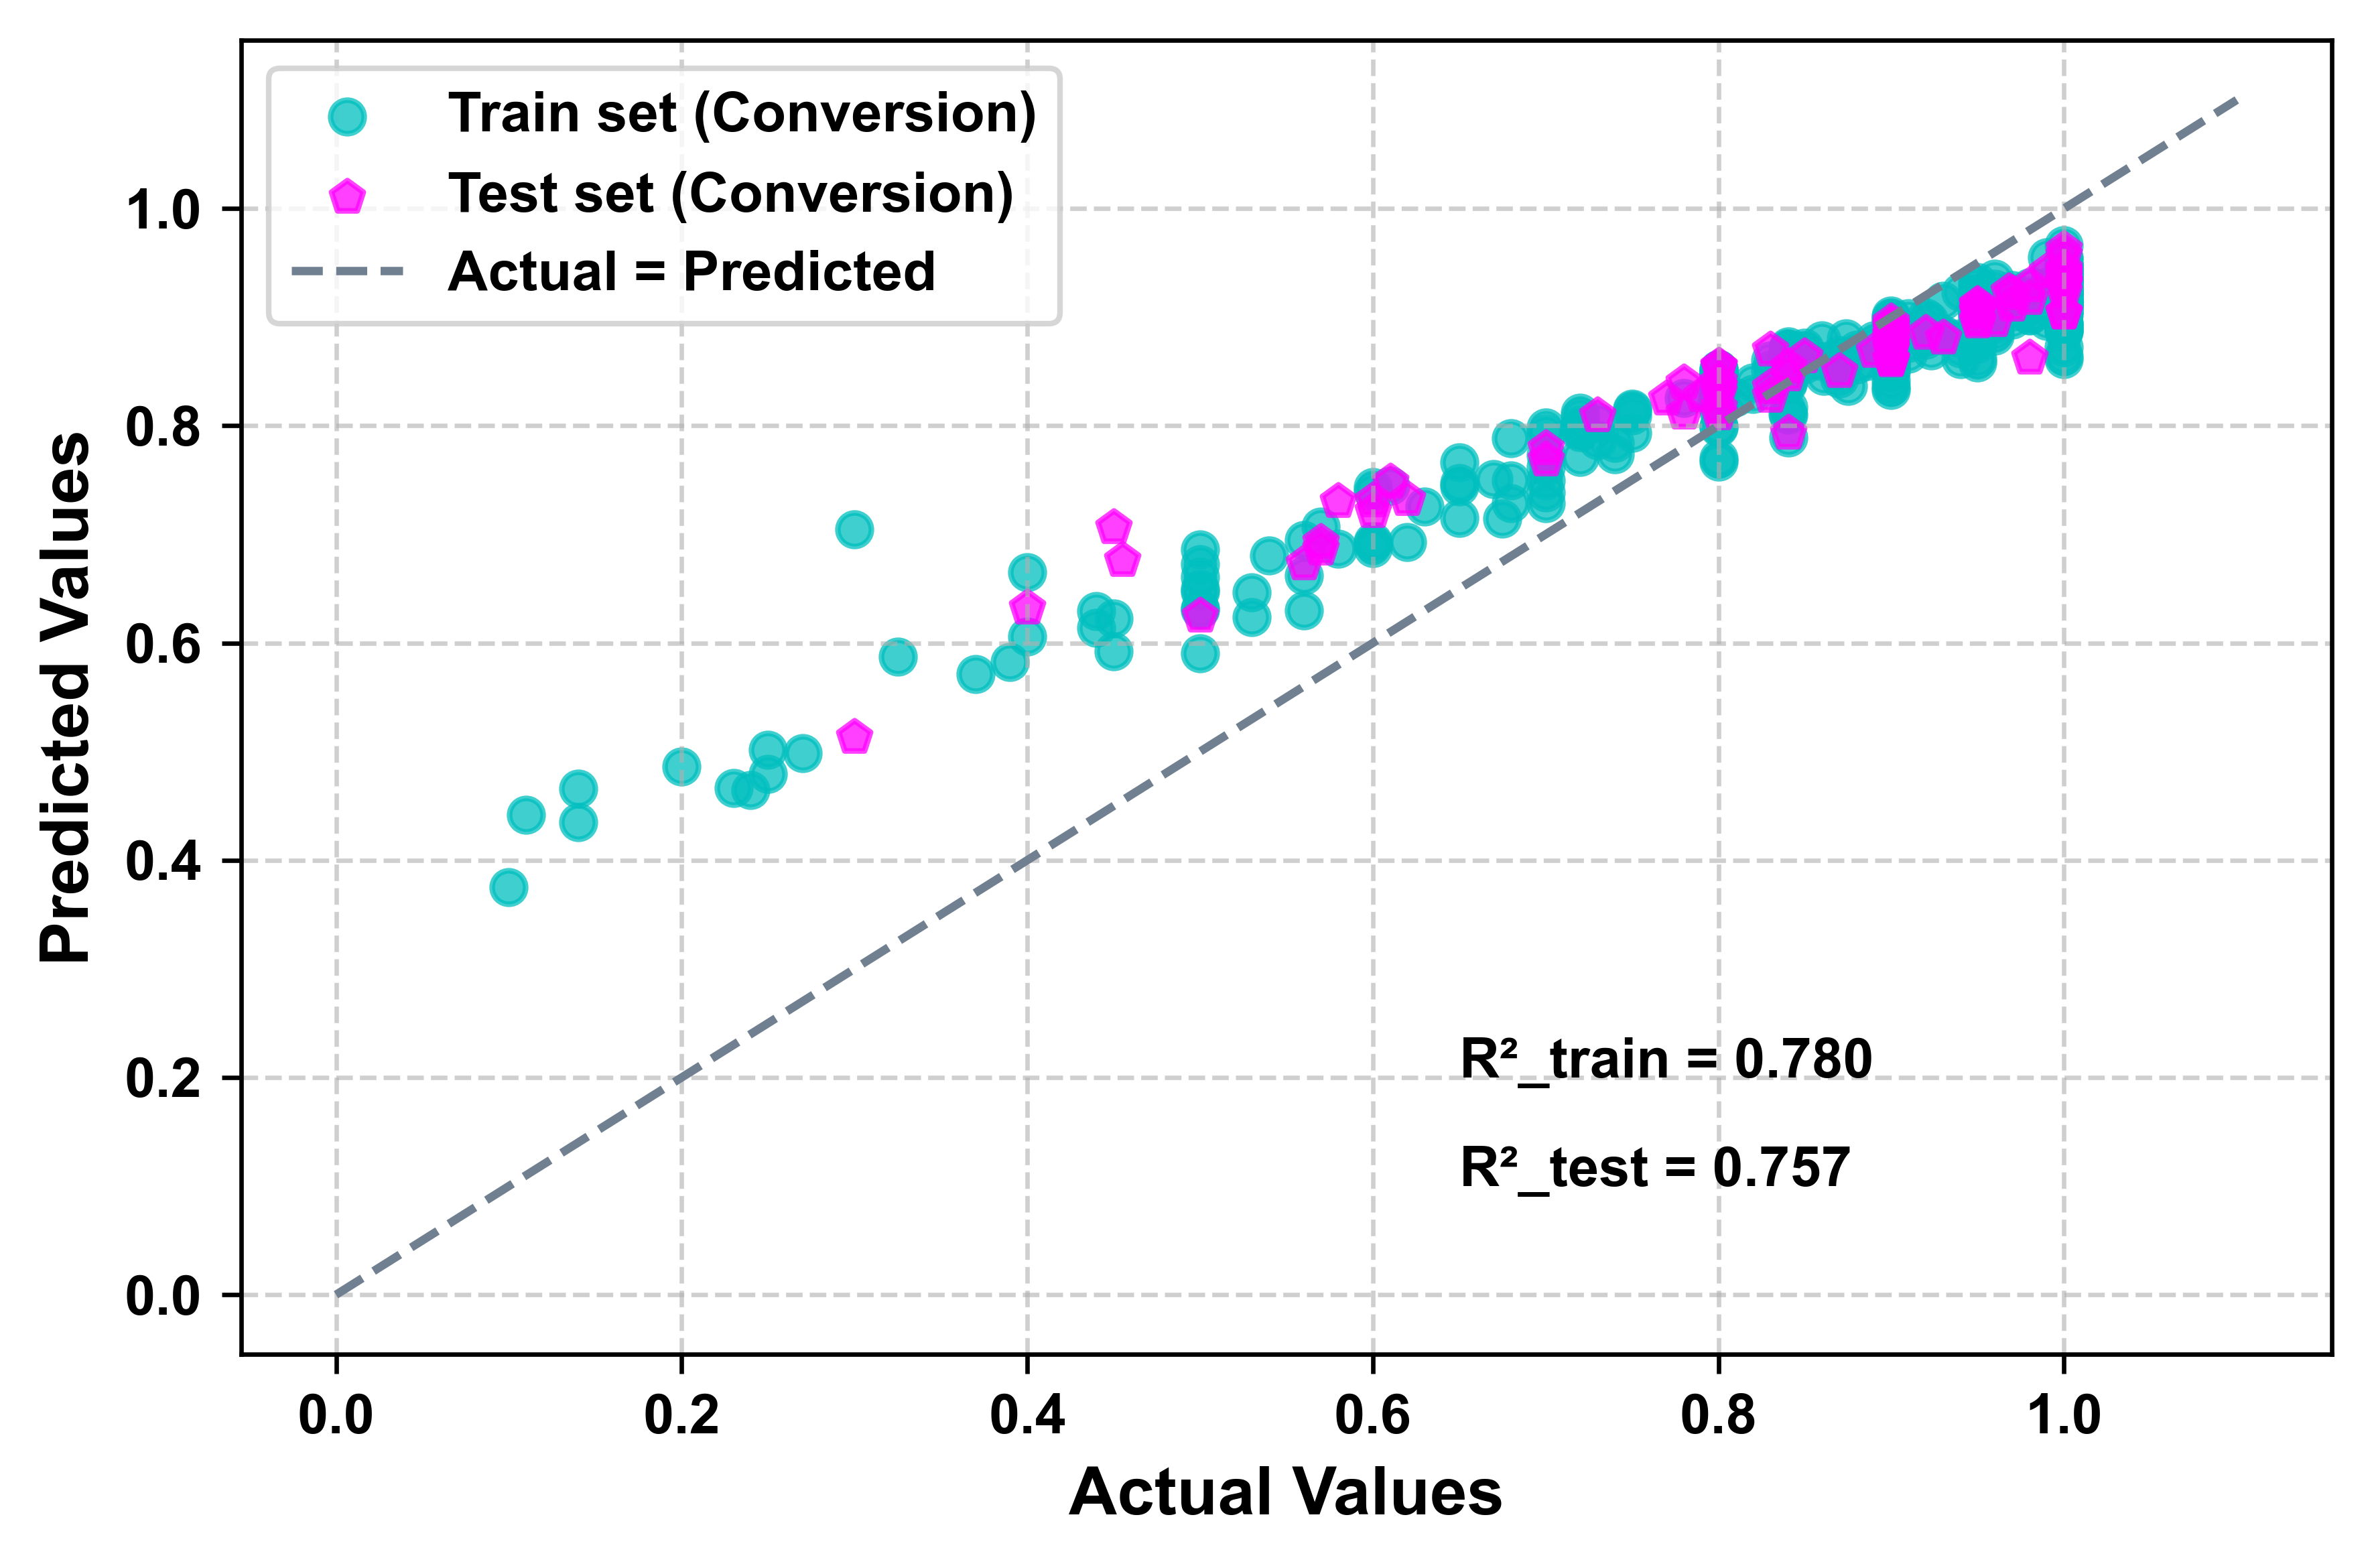

In [19]:
%%time
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],            
    'max_depth': [None, 10, 20, 30, 40, 50],              
    #'min_samples_split': [2, 5, 10],                     
    #'min_samples_leaf': [1, 2, 4],                       
    'max_features': ['auto', 'sqrt', 'log2'],             
    #'bootstrap': [True, False],                          
    #'criterion': ['squared_error', 'absolute_error', 'poisson']  
}
x_train_rf_o,x_test_rf_o, y_train_rf_o,y_test_rf_o,y_pred_rf_o,y_pred_train_rf_o,grid_model_rf_o = model_tuning(
    x_method_material_systhesis_condition, np.ravel(y_Conversion),RandomForestRegressor(random_state=6),rf_param_grid
)

#### xgboost

In [20]:
x_method_material_systhesis_condition.columns = list(range(399))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
 MSE_train: 0.0118, R2: 0.6427
 MSE_test: 0.0122, R2: 0.5002


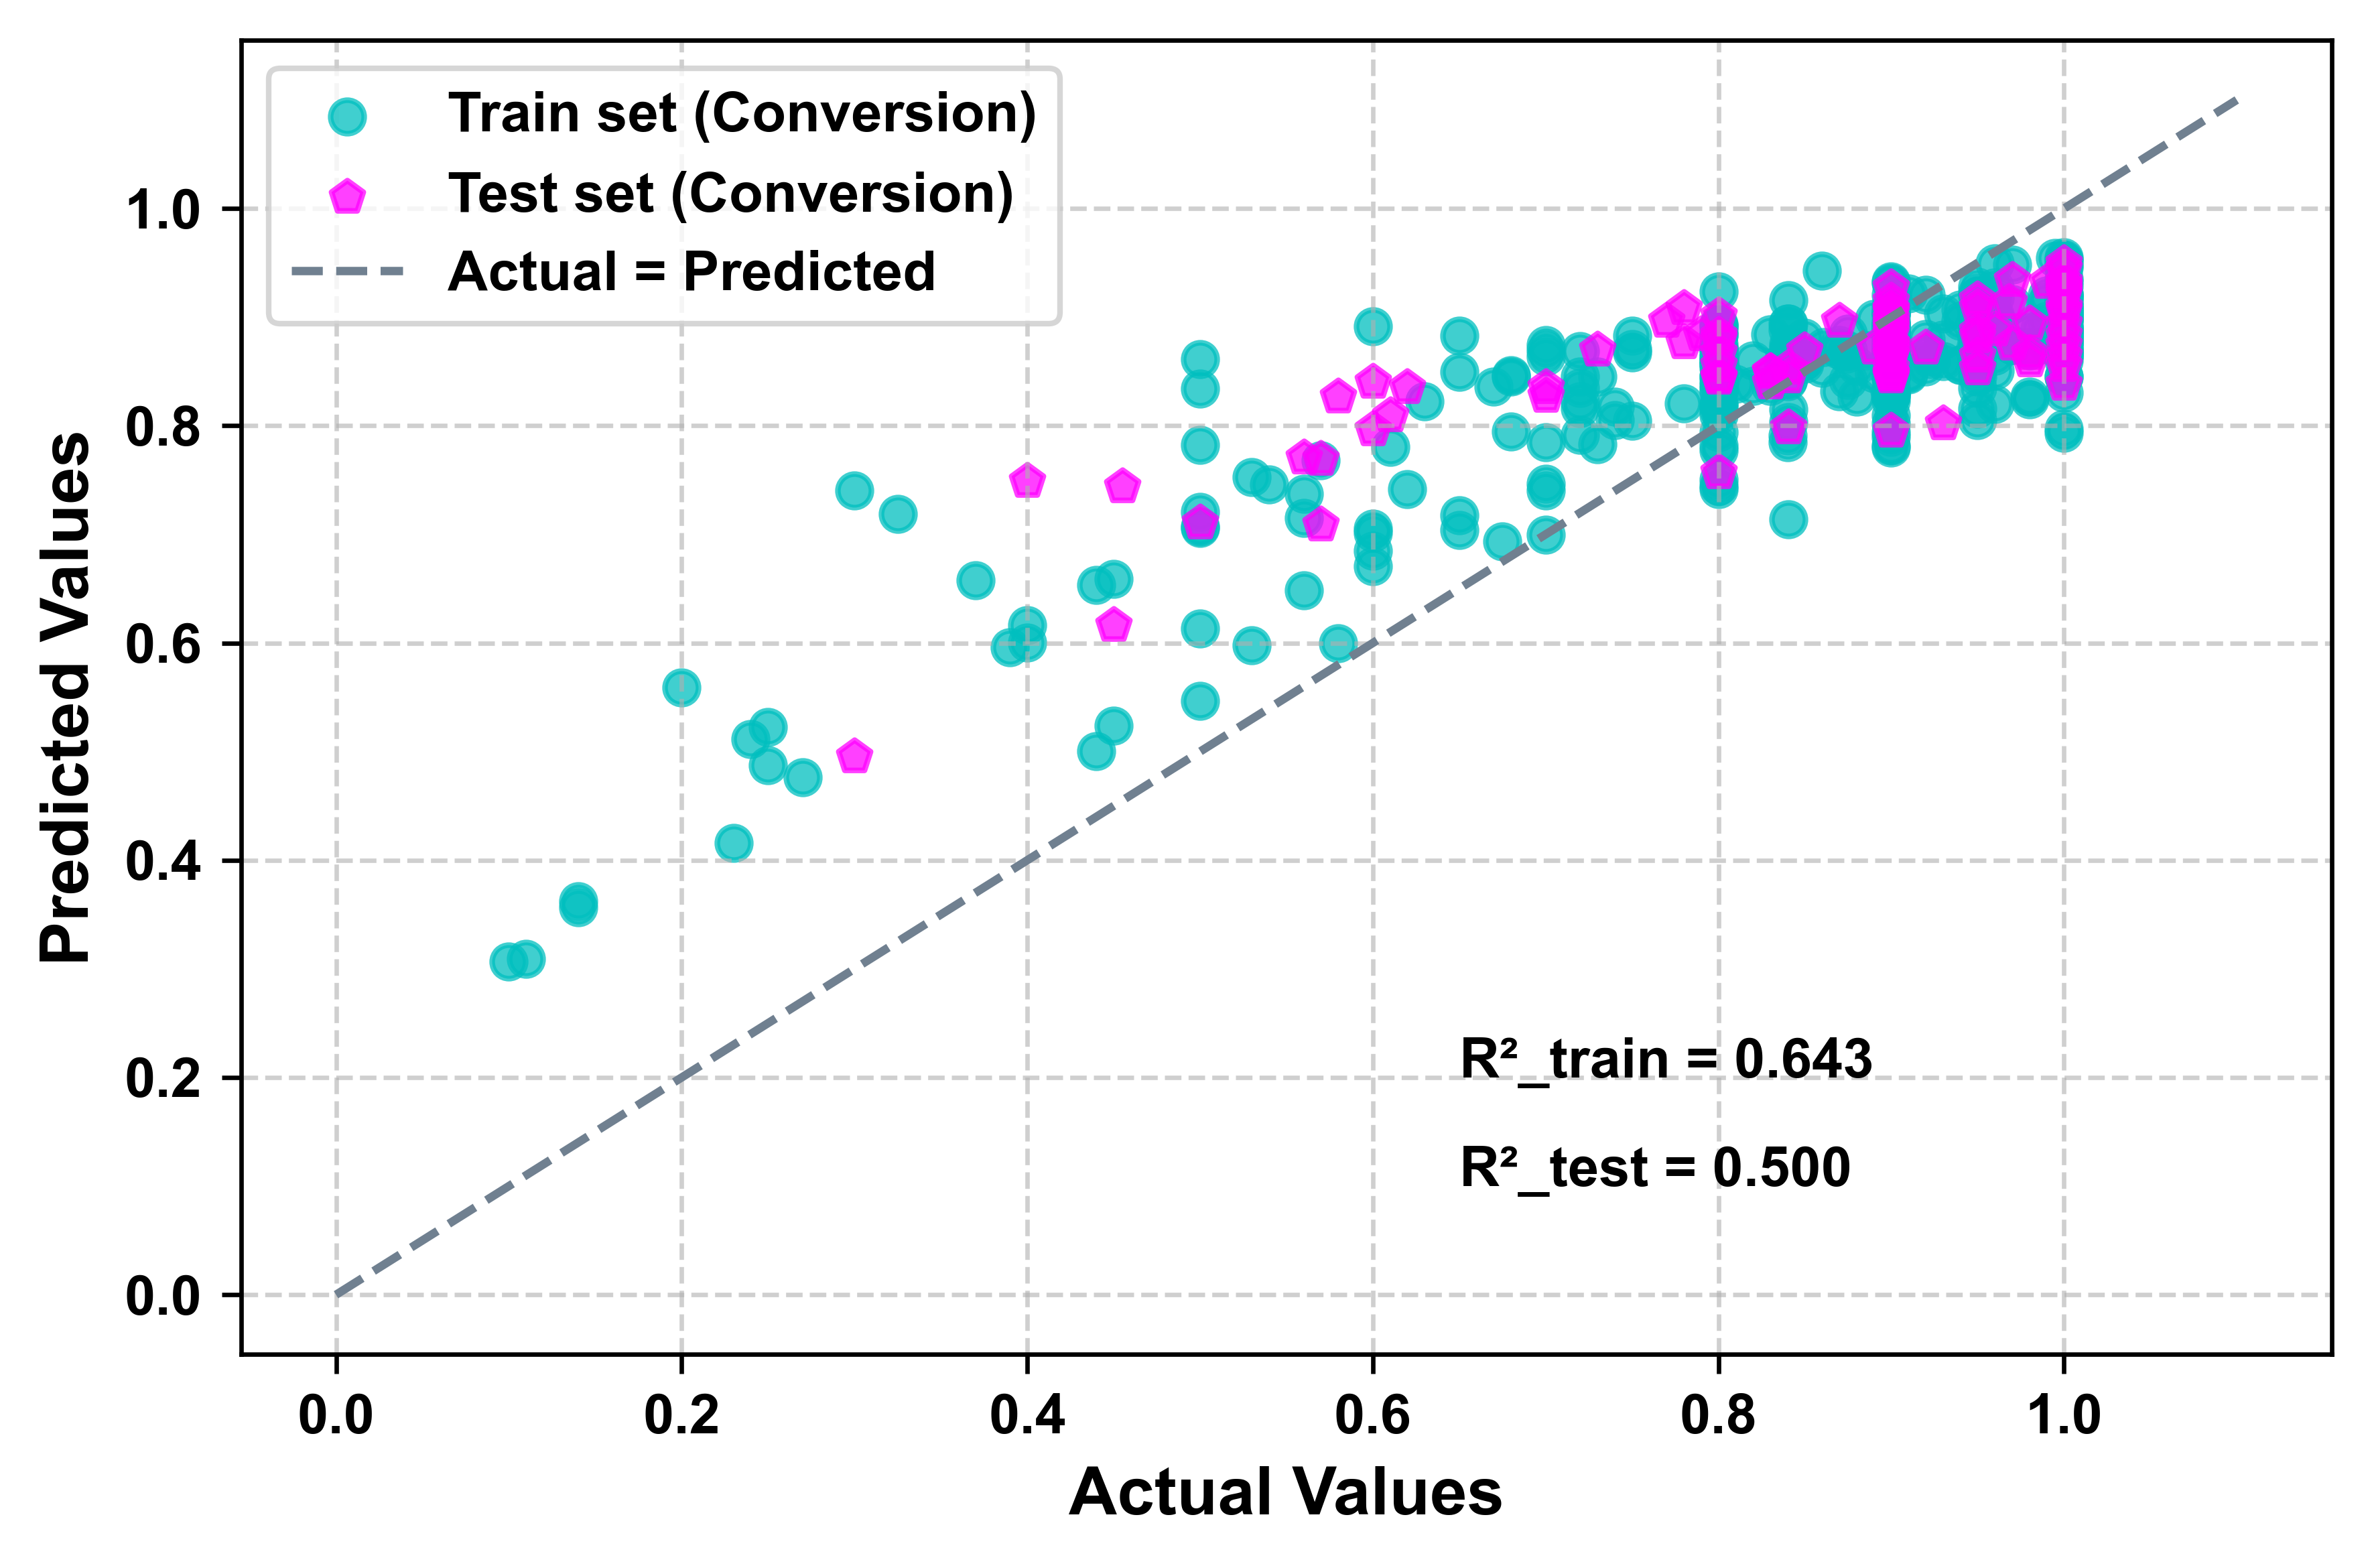

In [21]:
xgb_param_grid = {
        "max_depth": [3, 4, 5, 6, 7],
        #"learning_rate": [0.01, 0.1, 0.5, 1, 2, 5, 10],
        "n_estimators": [30, 50, 60, 100, 150, 200],
        "min_child_weight": [0.5, 1, 2, 3],
        #"gamma": [0, 0.1, 0.5, 1, 2, 3, 5]
    }

x_train_xgb_o,x_test_xgb_o, y_train_xgb_o,y_test_xgb_o,y_pred_xgb_o,y_pred_train_xgb_o,grid_model_xgb_o = model_tuning(
    x_method_material_systhesis_condition, np.ravel(y_Conversion),xgb.XGBRegressor(),xgb_param_grid
)

## ascii_materials

### 4_method_ascii_systhesis_condition

In [22]:
x_method_ascii_systhesis_condition = pd.concat([x_method,x_materials_ascii,x_synthesis,x_temperature_clean,x_GHSV_clean],axis=1)

In [23]:
x_method_ascii_systhesis_condition_nor = Normalizer().fit_transform(x_method_ascii_systhesis_condition)

#### rf

 MSE_train: 0.0086, R2: 0.7374
- MSE_test: 0.0067, R2: 0.7280


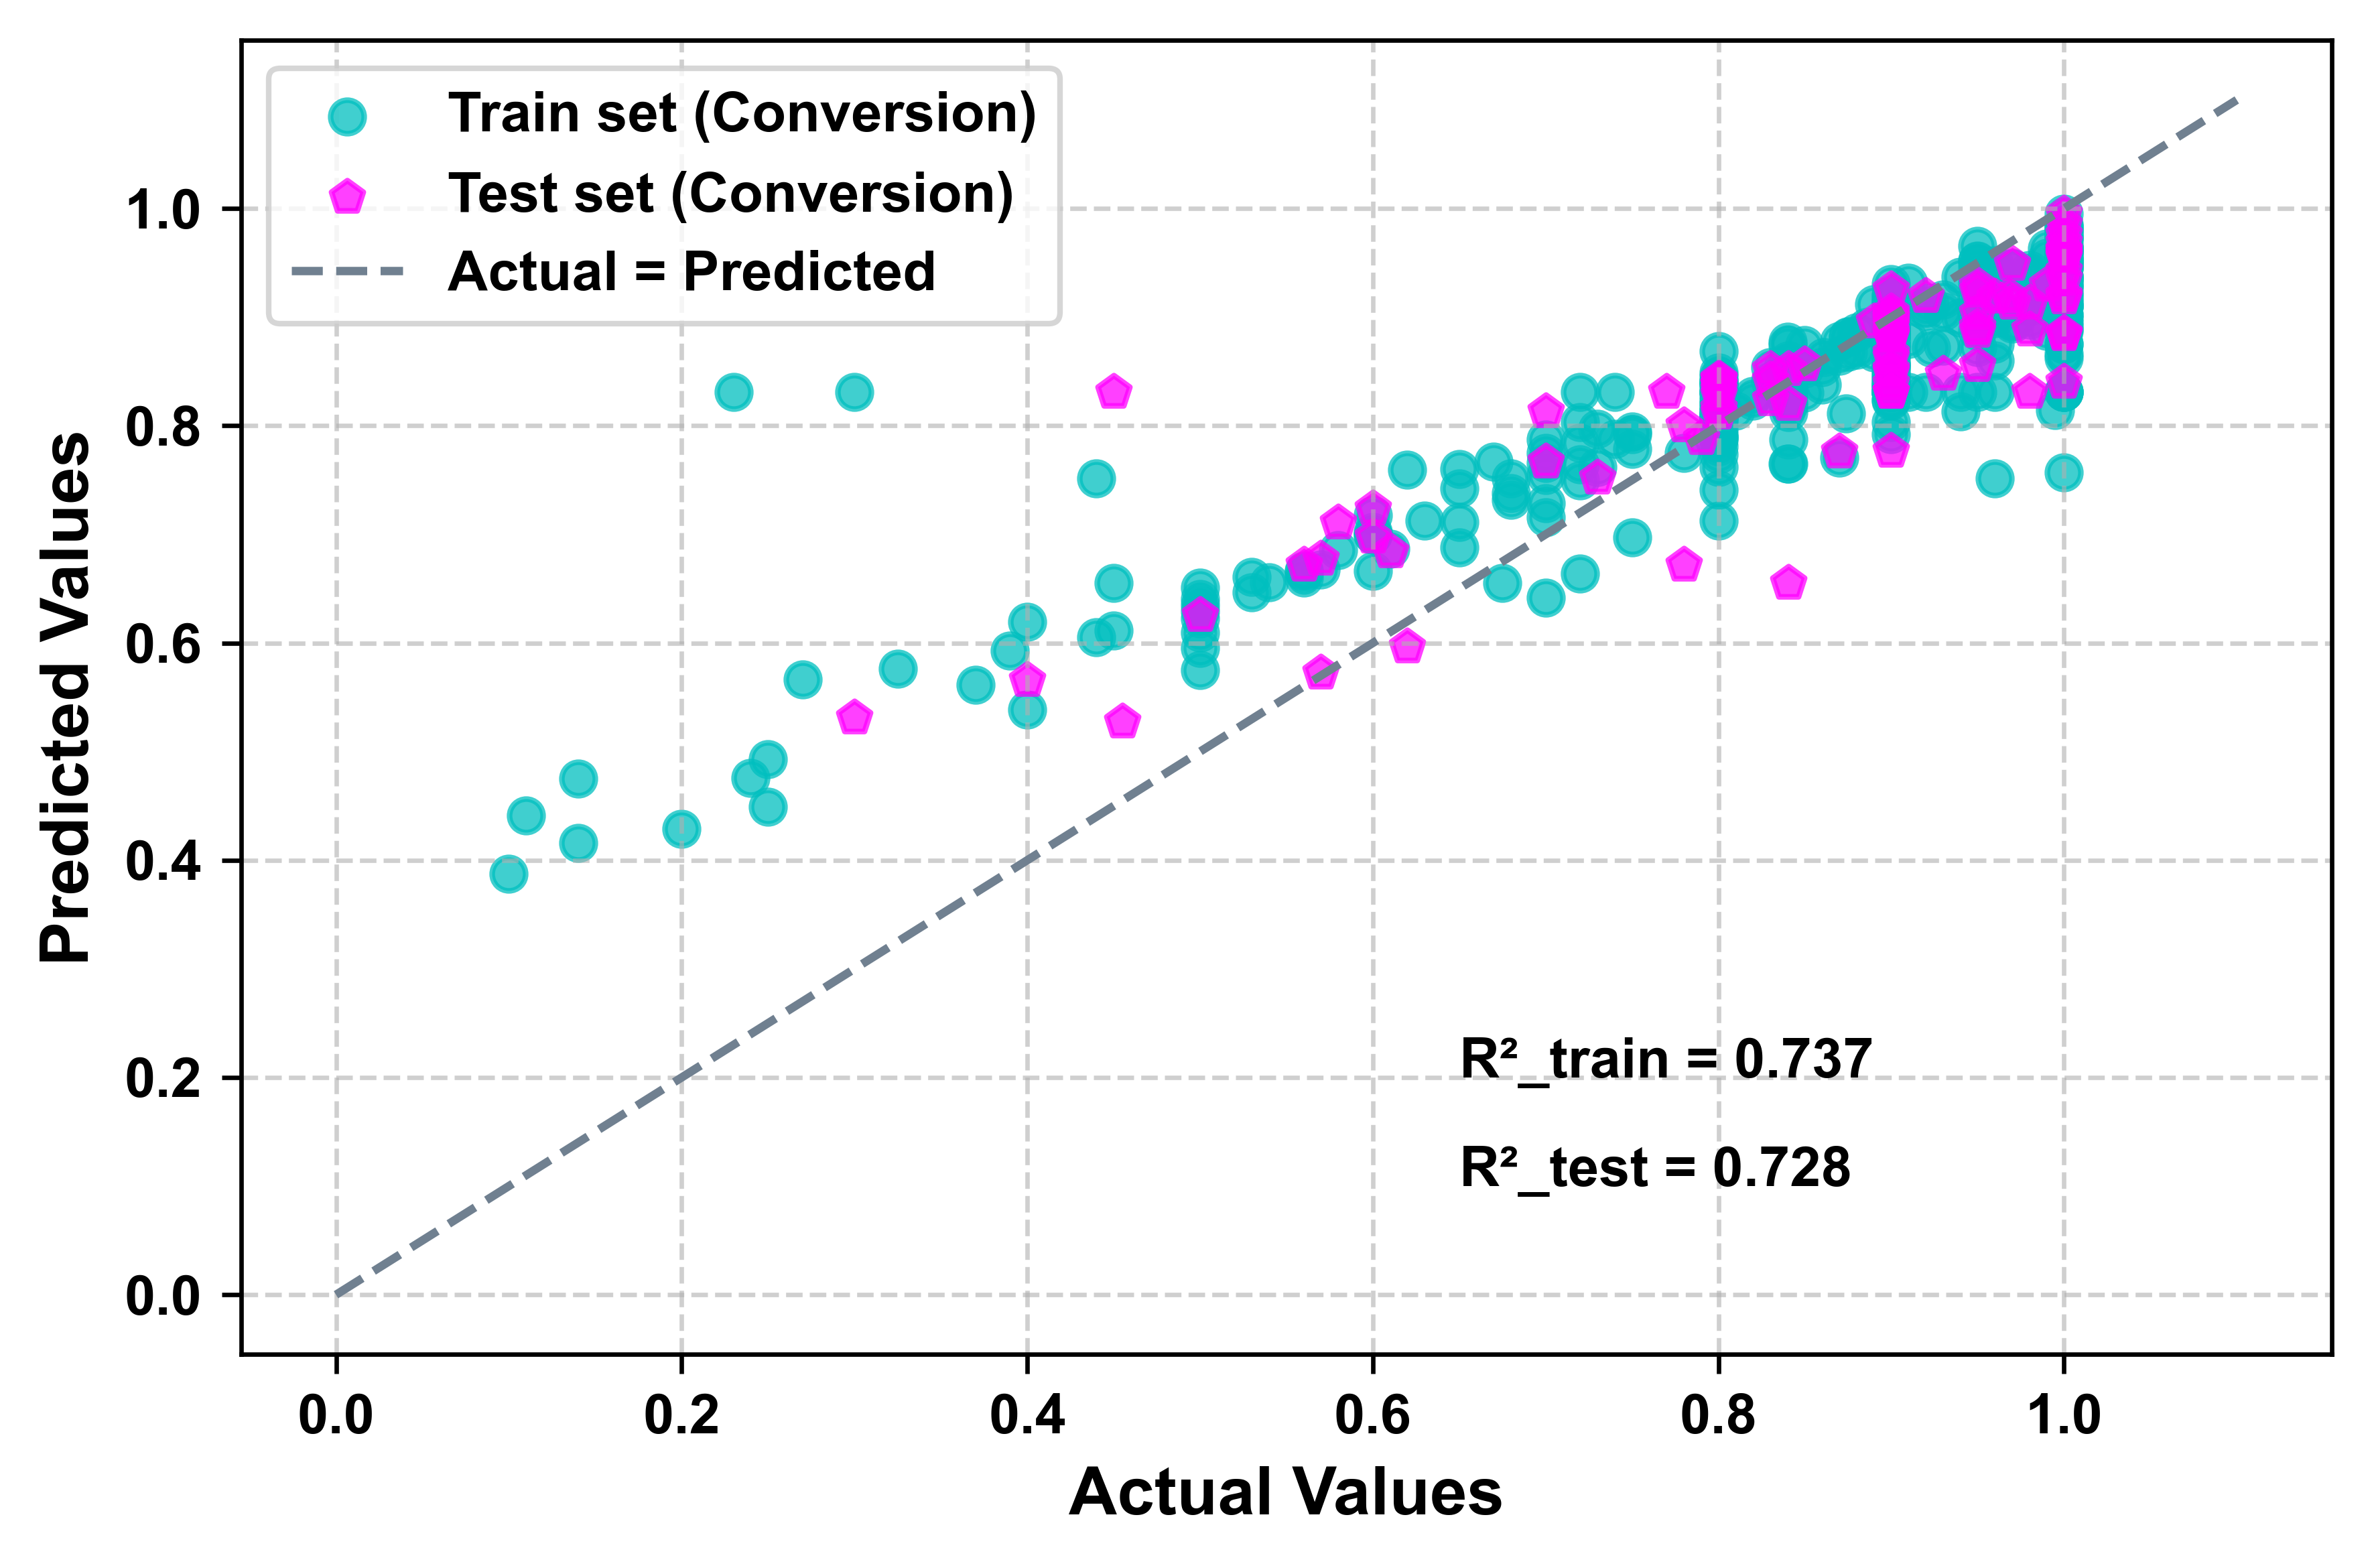

In [24]:
x_train_a, x_test_a, y_train_a,y_test_a,y_pred_a,y_pred_train_a,model_rf_a = model_train(x_method_ascii_systhesis_condition_nor, np.ravel(y_Conversion),RandomForestRegressor(random_state=6))

#### xgb

Fitting 5 folds for each of 120 candidates, totalling 600 fits
 MSE_train: 0.0114, R2: 0.6543
 MSE_test: 0.0085, R2: 0.6550


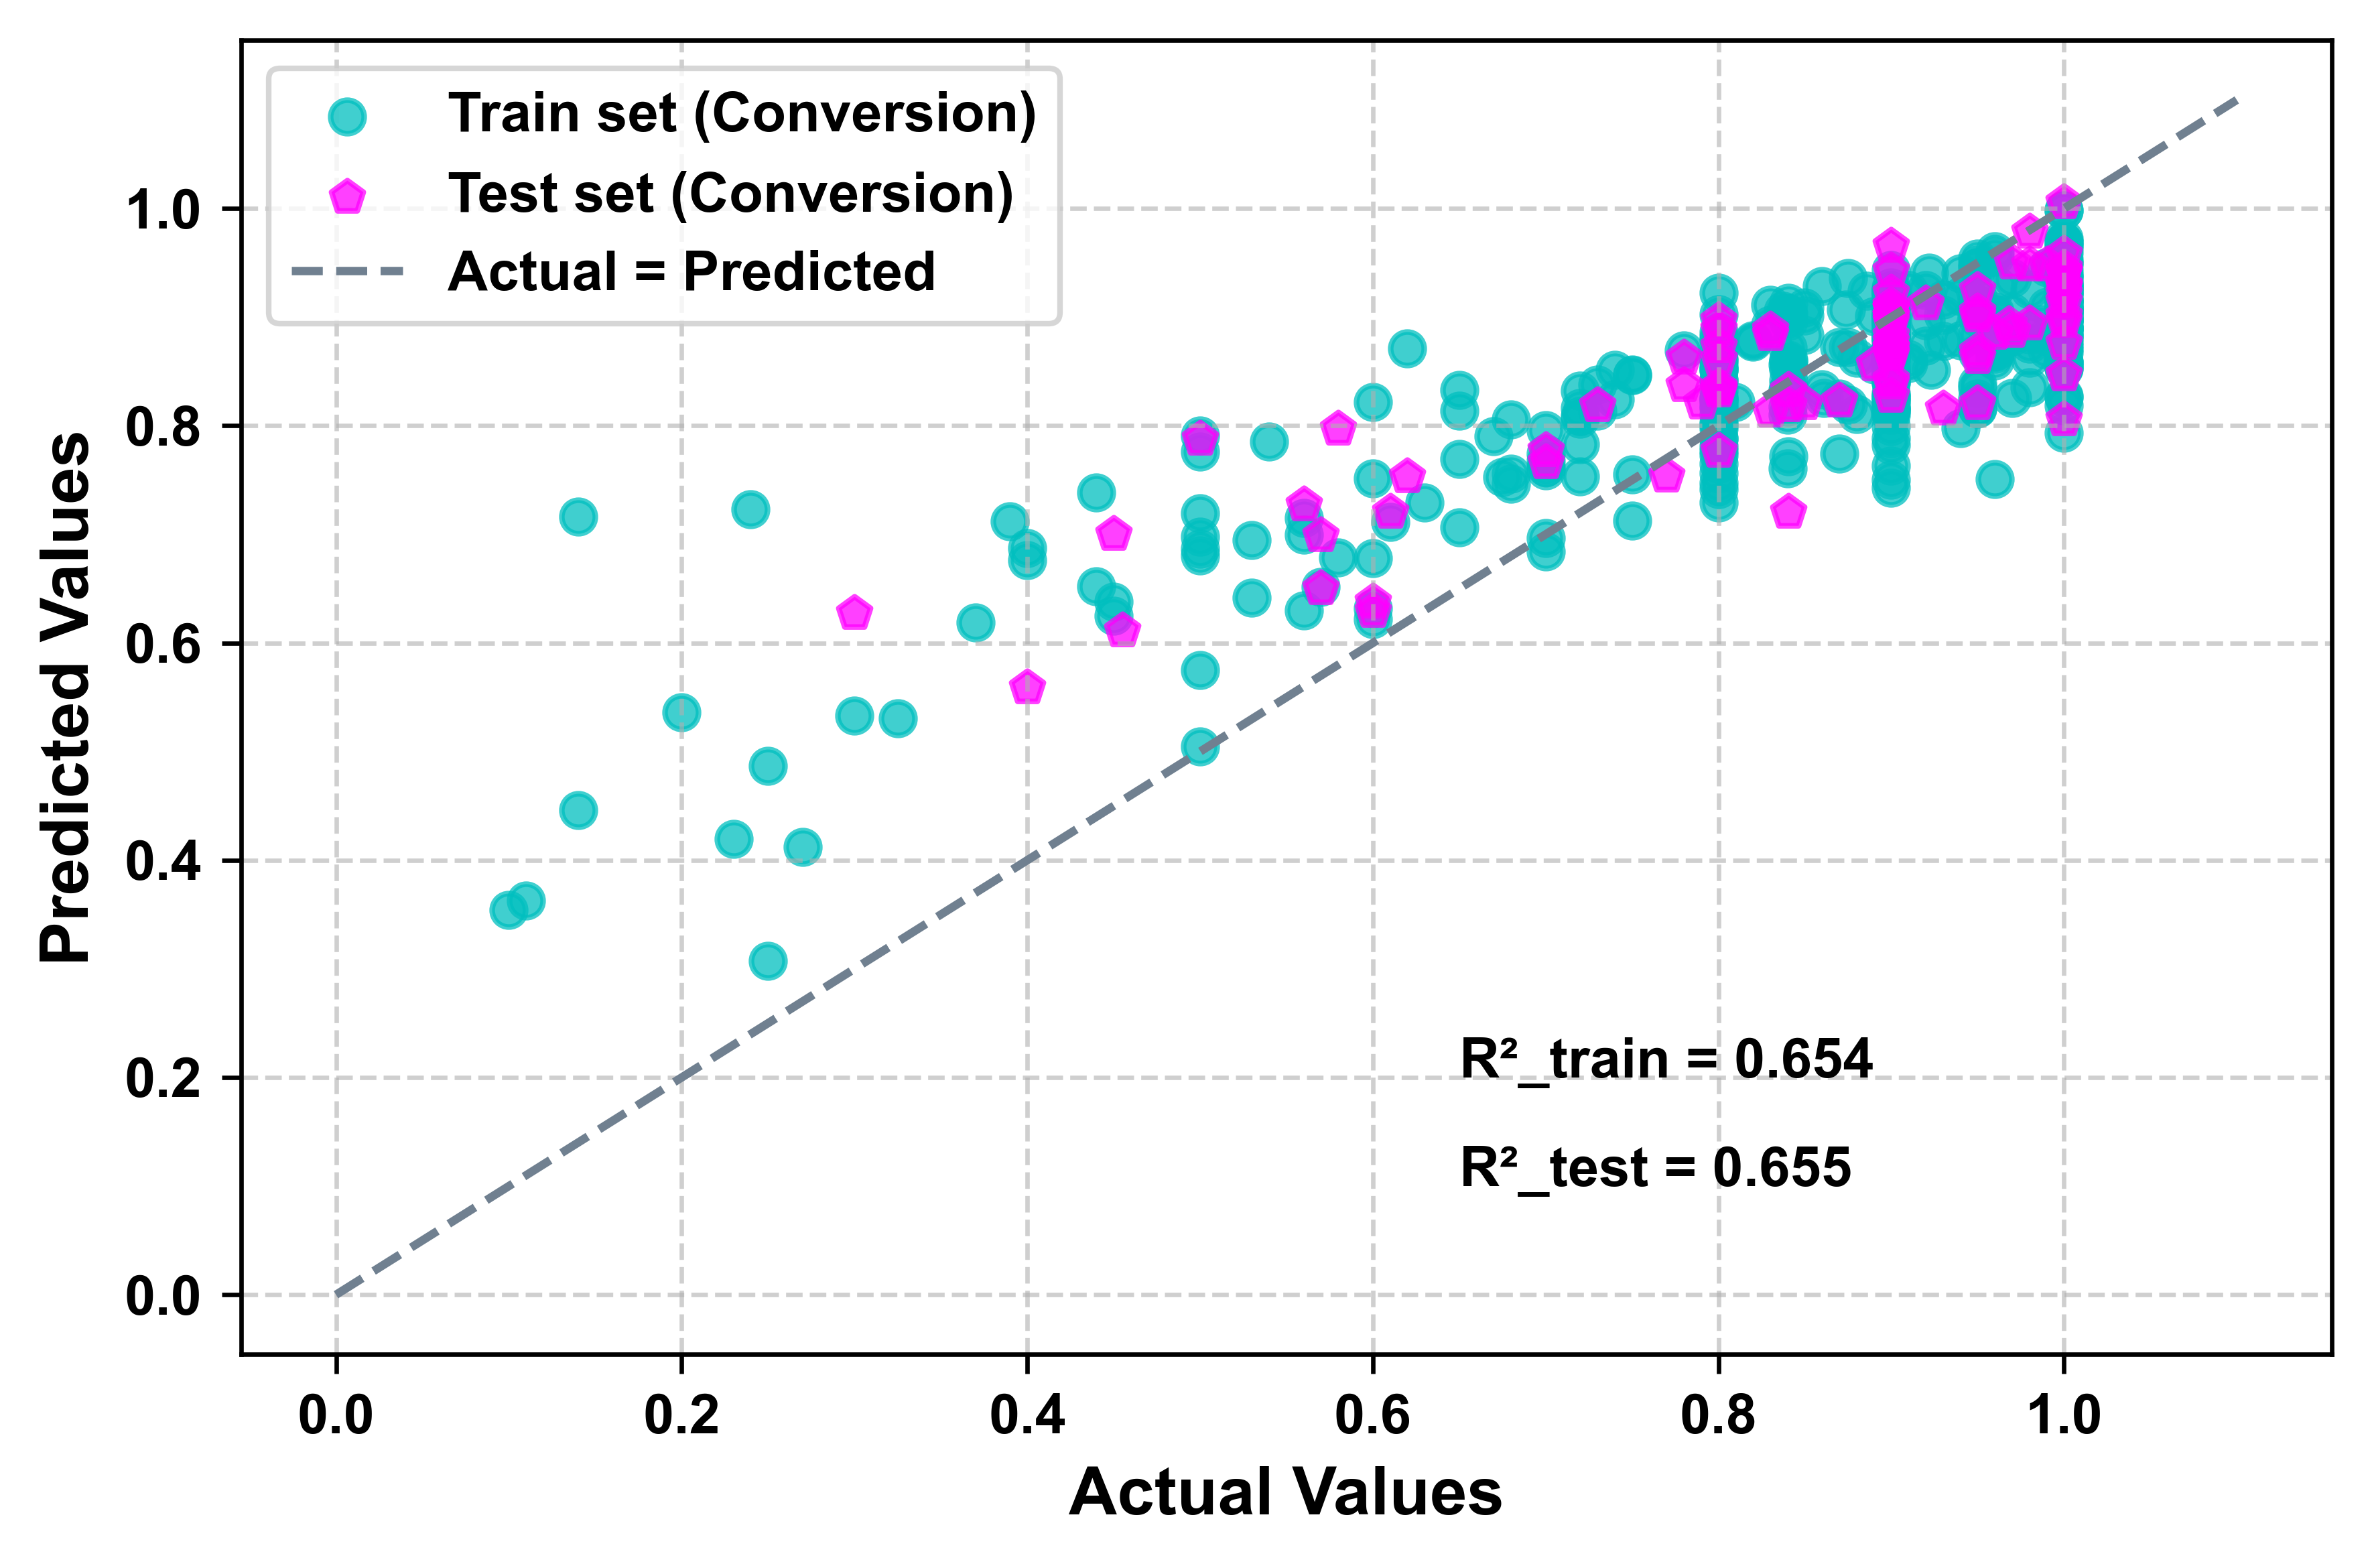

In [25]:
x_train_xgb_a,x_test_xgb_a,y_train_xgb_a,y_test_xgb_a,y_pred_xgb_a,y_pred_train_xgb_a,grid_model_xgb_a = model_tuning(x_method_ascii_systhesis_condition_nor,np.ravel(y_Conversion),xgb.XGBRegressor(),xgb_param_grid)

In [30]:
x_method_ascii_systhesis_condition

solid  sol-gel  impregnation  hydrothermal  co-precipitation  \
0        1        0             0             0                 0   
1        0        1             0             0                 0   
2        0        0             0             0                 0   
3        0        0             0             0                 0   
4        0        1             1             0                 0   
..     ...      ...           ...           ...               ...   
441      0        0             0             1                 0   
442      0        0             1             0                 0   
443      0        0             1             0                 0   
444      0        0             0             0                 0   
445      0        0             0             0                 1   

     ion-exchange  deposition  template  two-step postsynthesis  thermal  ...  \
0               0           0         0                       0        0  ...   
1               0           0         0                       0        0  ...   
2               0           0         0                       0        0  ...   
3               0           0         0                       0        1  ...   
4               0           0         0                       0        0  ...   
..            ...         ...       ...                     ...      ...  ...   
441             0           0         0                       0        1  ...   
442             0           0         0                       0        0  ...   
443             0           0         0                       0        0  ...   
444             0           0         0                       0        0  ...   
445             0           0         0                       0        0  ...   

     vaps  crushs  sieves  mixs  dissolves  stirs  impregnates  grind  \
0       0       1       1     1          0      0            0      1   
1       0       0       0     0          1      1            0      0   
2       1       0       0     0          1      1            1      0   
3       0       0       0     1          0      0            0      0   
4       0       0       0     0          0      0            1      0   
..    ...     ...     ...   ...        ...    ...          ...    ...   
441     0       0       0     1          0      1            0      0   
442     0       0       0     0          1      0            1      0   
443     1       0       0     0          0      1            1      0   
444     0       0       0     0          0      1            1      0   
445     0       0       0     0          0      1            0      0   

     temperature_K_average  GHSV_average(h-1)  
0                   298.15       50000.000000  
1                   498.15       50976.164706  
2                   723.00       10000.000000  
3                   673.15       66845.000000  
4                   298.15       10000.000000  
..                     ...                ...  
441                 773.00       15000.000000  
442                 453.15       60000.000000  
443                 523.15       50976.164706  
444                 613.15       66845.000000  
445                 573.15       50976.164706  

[446 rows x 49 columns]

In [33]:
a = ['solid', 'sol-gel', 'impregnation', 'hydrothermal', 'co-precipitation',
       'ion-exchange', 'deposition', 'template', 'postsynthesis',
       'thermal', 'acid', 'calcination', 'incipient', 'one-step', 'other',
       'material1', 'material2', 'material3', 'material4', 'material5',
       'material6', 'material7', 'material8', 'material9', 'material10',
       'material11', 'material12', 'dry', 'dry_temperature', 'dry_time',
       'calcined', 'calcined_temperature', 'calcined_time', 'exchange',
       'age', 'age_temperature', 'age_time', 'filter', 'wash', 'evaporative',
       'crush', 'sieve', 'mix', 'dissolve', 'stir', 'impregnate',
       'grind','RT','GHSV']

In [35]:
x_method_ascii_systhesis_condition.columns = a

In [38]:
corr = pd.DataFrame(x_method_ascii_systhesis_condition).corr()

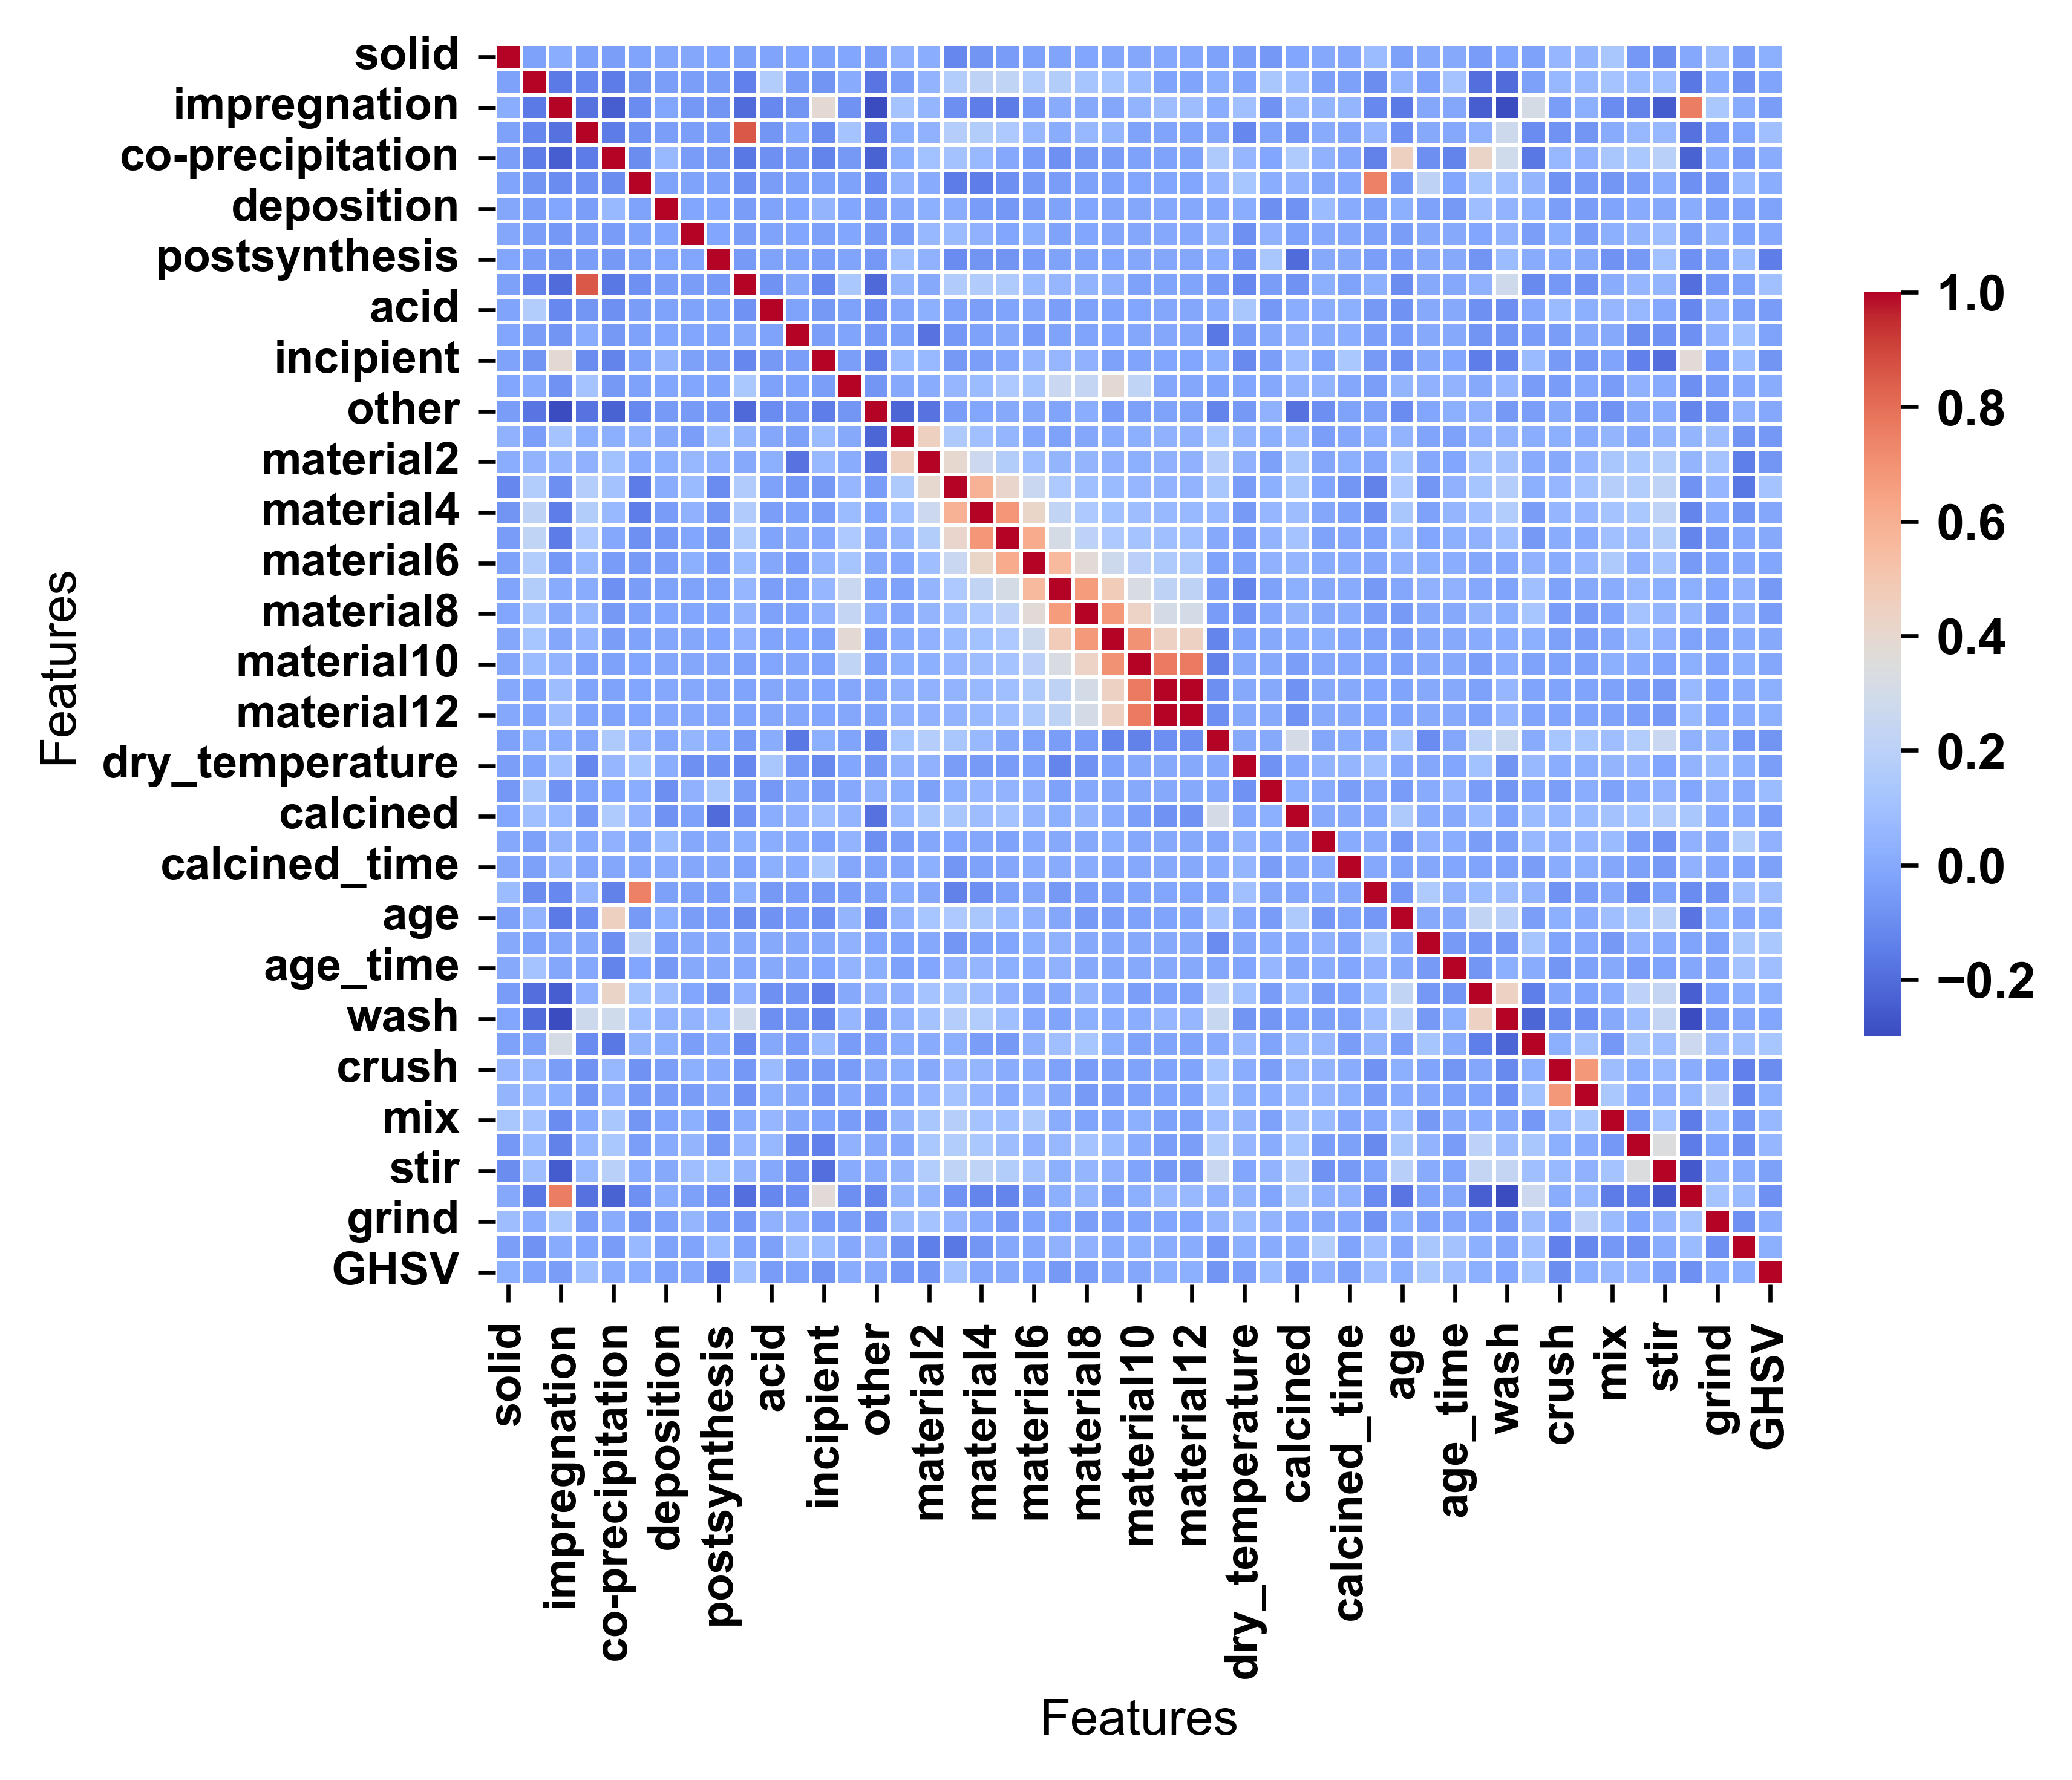

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 corr 是你的相关性矩阵
plt.figure(figsize=(6, 5),dpi=600)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold' 
# 画热力图
sns.heatmap(corr, fmt='.2f', cmap='coolwarm', 
            cbar_kws={'shrink': 0.6}, linewidths=0.5)

# 修改字体
plt.xticks(fontsize=9, fontname='Arial')
plt.yticks(fontsize=9, fontname='Arial')
plt.xlabel('Features',fontsize=10, fontname='Arial')
plt.ylabel('Features',fontsize=10, fontname='Arial')

# 清晰度设置
plt.tight_layout()
# 保存为矢量图（SVG 或 PDF）
plt.savefig('heatmap.svg')  # 或者使用 'heatmap.pdf'

In [57]:
x_new_columns


['solid',
 'sol-gel',
 'impregnation',
 'hydrothermal',
 'co-precipitation',
 'ion-exchange',
 'deposition',
 'template',
 'postsynthesis',
 'thermal',
 'acid',
 'calcination',
 'incipient',
 'one-step',
 'other',
 'material1',
 'material2',
 'material3',
 'material4',
 'material5',
 'material6',
 'material7',
 'material8',
 'material9',
 'material10',
 'material11',
 'material12',
 'dry',
 'dry_temperature',
 'dry_time',
 'calcined',
 'calcined_temperature',
 'calcined_time',
 'exchange',
 'age',
 'age_temperature',
 'age_time',
 'filter',
 'wash',
 'evaporative',
 'crush',
 'sieve',
 'mix',
 'dissolve',
 'stir',
 'impregnate',
 'grind']

In [28]:
'''
column_sums = x.sum()

# 找到和小于 10 的列名
columns_less_than_n = column_sums[column_sums < 1].index.tolist()
# 返回结果
print(columns_less_than_n)
x_sum_less = x.drop(columns=columns_less_than_n)
x_sum_less.shape

'''


'\ncolumn_sums = x.sum()\n\n# 找到和小于 10 的列名\ncolumns_less_than_n = column_sums[column_sums < 1].index.tolist()\n# 返回结果\nprint(columns_less_than_n)\nx_sum_less = x.drop(columns=columns_less_than_n)\nx_sum_less.shape\n\n'

# figure

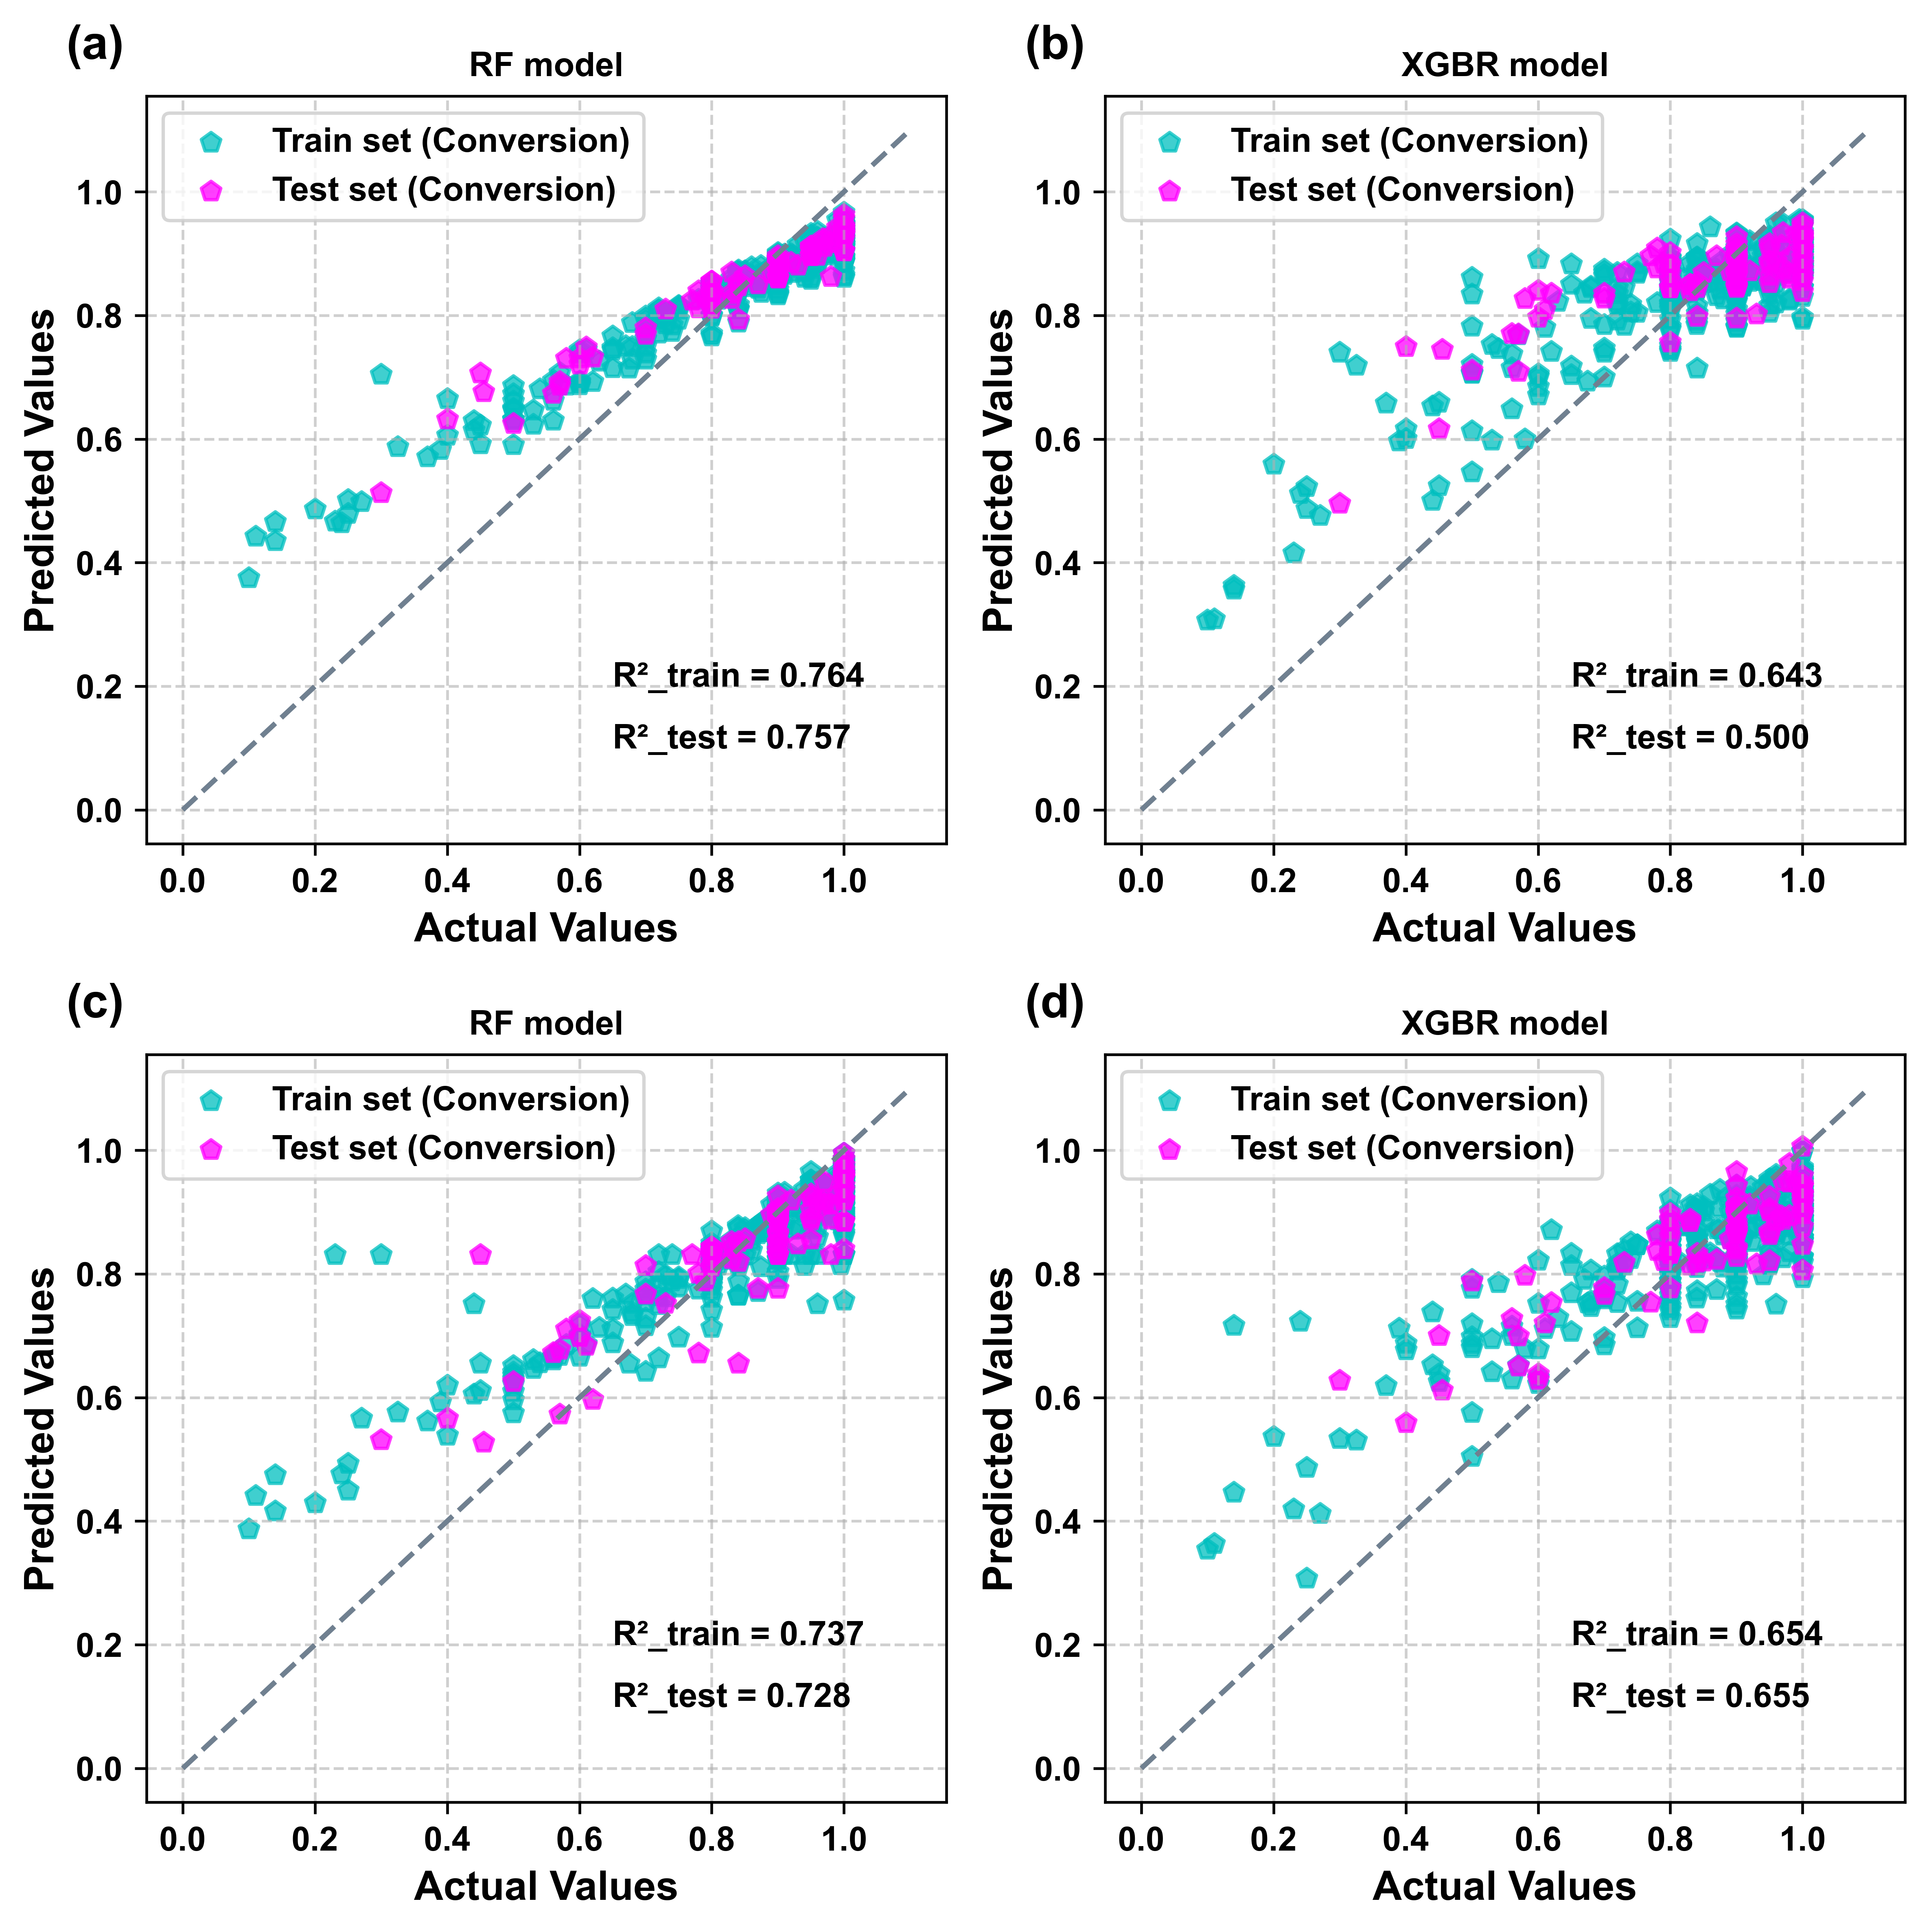

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'

fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=600)  

# 第一个图
axs[0, 0].scatter(y_train_rf_o, y_pred_train_rf_0, color='c', marker='p', alpha=0.75, label='Train set (Conversion)')
axs[0, 0].scatter(y_test_rf_0, y_pred_rf_o, color='Magenta', marker='p', alpha=0.75, label='Test set (Conversion)')
axs[0, 0].plot([0, 1.1], [0, 1.1], color='SlateGray', linestyle='--', label='_nolegend_')
axs[0, 0].set_title('RF model', fontsize=10, fontweight='bold')
axs[0, 0].set_xlabel('Actual Values', fontsize=12, fontweight='bold')
axs[0, 0].set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
axs[0, 0].text(0.65, 0.2, 'R²_train = 0.764', fontsize=10, color='black')
axs[0, 0].text(0.65, 0.1, 'R²_test = 0.757', fontsize=10, color='black')
axs[0, 0].text(-0.1, 1.05, '(a)', fontsize=14, fontweight='bold', transform=axs[0, 0].transAxes)

axs[0, 1].scatter(y_train_xgb_o, y_pred_train_xgb_o, color='c', marker='p', alpha=0.75, label='Train set (Conversion)')
axs[0, 1].scatter(y_test_xgb_o, y_pred_xgb_o, color='Magenta', marker='p', alpha=0.75, label='Test set (Conversion)')
axs[0, 1].plot([0, 1.1], [0, 1.1], color='SlateGray', linestyle='--', label='_nolegend_')
axs[0, 1].set_title('XGBR model', fontsize=10, fontweight='bold')
axs[0, 1].set_xlabel('Actual Values', fontsize=12, fontweight='bold')
axs[0, 1].set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
axs[0, 1].text(0.65, 0.2, 'R²_train = 0.643', fontsize=10, color='black')
axs[0, 1].text(0.65, 0.1, 'R²_test = 0.500', fontsize=10, color='black')
axs[0, 1].text(-0.1, 1.05, '(b)', fontsize=14, fontweight='bold', transform=axs[0, 1].transAxes)

# 第三个图
axs[1, 0].scatter(y_train_a, y_pred_train_a, color='c', marker='p', alpha=0.75, label='Train set (Conversion)')
axs[1, 0].scatter(y_test_a, y_pred_a, color='Magenta', marker='p', alpha=0.75, label='Test set (Conversion)')
axs[1, 0].plot([0, 1.1], [0, 1.1], color='SlateGray', linestyle='--', label='_nolegend_')
axs[1, 0].set_title('RF model', fontsize=10, fontweight='bold')
axs[1, 0].set_xlabel('Actual Values', fontsize=12, fontweight='bold')
axs[1, 0].set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
axs[1, 0].text(0.65, 0.2, 'R²_train = 0.737', fontsize=10, color='black')
axs[1, 0].text(0.65, 0.1, 'R²_test = 0.728', fontsize=10, color='black')
axs[1, 0].text(-0.1, 1.05, '(c)', fontsize=14, fontweight='bold', transform=axs[1, 0].transAxes)

axs[1, 1].scatter(y_train_xgb_a, y_pred_train_xgb_a, color='c', marker='p', alpha=0.75, label='Train set (Conversion)')
axs[1, 1].scatter(y_test_xgb_a, y_pred_xgb_a, color='Magenta', marker='p', alpha=0.75, label='Test set (Conversion)')
axs[1, 1].plot([0, 1.1], [0, 1.1], color='SlateGray', linestyle='--', label='_nolegend_')
axs[1, 1].set_title('XGBR model', fontsize=10, fontweight='bold')
axs[1, 1].set_xlabel('Actual Values', fontsize=12, fontweight='bold')
axs[1, 1].set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
axs[1, 1].text(0.65, 0.2, 'R²_train = 0.654', fontsize=10, color='black')
axs[1, 1].text(0.65, 0.1, 'R²_test = 0.655', fontsize=10, color='black')
axs[1, 1].text(-0.1, 1.05, '(d)', fontsize=14, fontweight='bold', transform=axs[1, 1].transAxes)


for ax in axs.flat:
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

axs[0, 0].legend(loc='upper left')
axs[0, 1].legend(loc='upper left')
axs[1, 0].legend(loc='upper left')
axs[1, 1].legend(loc='upper left')

# 显示图表

plt.savefig('conversion_ML.svg')  
plt.show()


In [190]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.3/459.3 kB 410.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.8/2.6 MB 866.7 kB/s eta 0:00:03

limit_output extension: Maximum message size of 10000 exceeded with 10082 characters

# shap

## materials_onehot

In [38]:
x_column1 = pd.concat([x_method,x_materials,x_synthesis,x_temperature_clean,x_GHSV_clean],axis=1)
x_column1 = x_column1.columns.tolist()[:]

In [39]:
x_column1[-2] = 'RT'
x_column1[-1] = 'GHSV'

In [40]:
x_train_rf_o.columns = x_column1

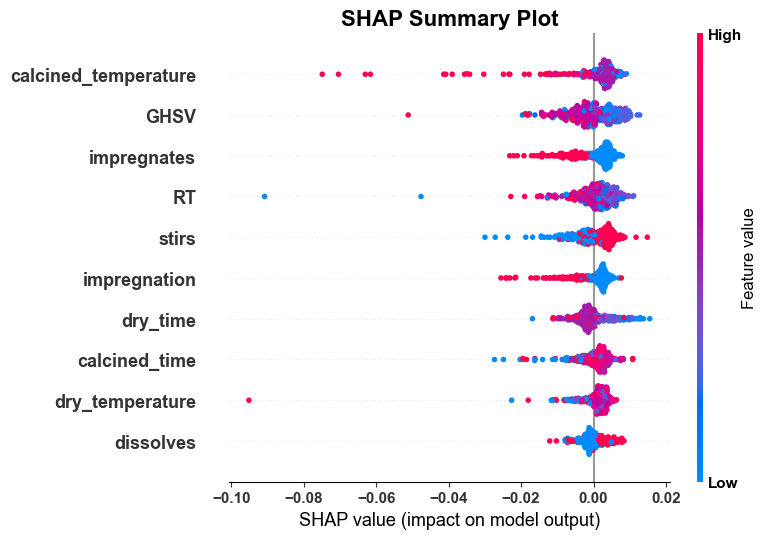

In [54]:

import shap

explainer = shap.TreeExplainer(grid_model_rf_o.best_estimator_)
shap_values = explainer.shap_values(x_train_rf_o)
plt.figure(figsize=(5, 4))
shap.summary_plot(shap_values, x_train_rf_o, plot_type="dot", show=False,max_display=10)  # show=False, 便于进一步美化

# 美化 summary_plot
plt.rcParams['font.family'] = 'Arial'
plt.title('SHAP Summary Plot', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.grid(False)
plt.savefig('Shap_conversion_rf_onehot.pdf',dpi=600)


## materials_ascll

In [47]:
x_column2 = x_method_ascii_systhesis_condition.columns.tolist()[:]

In [48]:
x_column2[-2] = 'RT'
x_column2[-1] = 'GHSV'

In [51]:
x_train_a= pd.DataFrame(x_train_a,columns=x_column2)

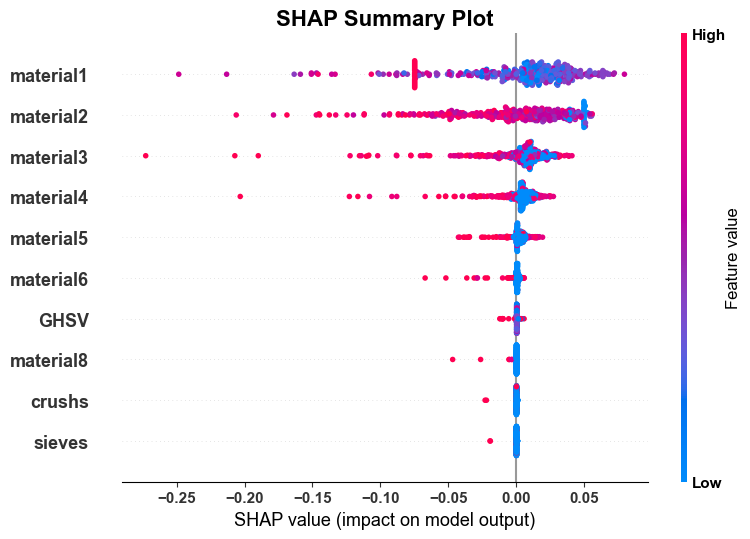

In [53]:
explainer = shap.TreeExplainer(model_rf_a)
shap_values = explainer.shap_values(x_train_a)
plt.figure(figsize=(5, 4))
shap.summary_plot(shap_values, x_train_a, plot_type="dot", show=False,max_display=10)  
plt.rcParams['font.family'] = 'Arial'
plt.title('SHAP Summary Plot', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.grid(False)
plt.savefig('Shap_conversion_rf_ascll.pdf',dpi=600)
